# Experiments in Scaling

In [2]:
from collections import OrderedDict

import numpy as np
from matplotlib import pyplot as plt
import torch as t
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms


In [3]:
def get_datasets() -> tuple[datasets.MNIST, datasets.MNIST]:
    train_set = datasets.MNIST(
            "data",
            train=True,
            download=True,
            transform=transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,)),
                ]
            ),
        )

    test_set = datasets.MNIST(
            "data",
            train=False,
            download=True,
            transform=transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,)),
                ]
            ),
        )

    return train_set, test_set

train_set, test_set = get_datasets()


In [4]:
def get_data_loader(
    train_set: datasets.MNIST, 
    batch_size=64,
    f_train=1.,
    seed=42
) -> DataLoader:
    """Get MNIST train and test data loaders. We train on a subset of the data"""
    np.random.seed(seed)

    train_indices = list(np.random.choice(
        np.arange(len(train_set)),
        size=int(f_train * len(train_set)),
        replace=False,
    ))

    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        sampler=sampler.SubsetRandomSampler(train_indices),
    )
    return train_loader

def get_test_loader(test_set: datasets.MNIST, batch_size=64) -> DataLoader:
    """Get MNIST test data loader."""
    test_loader = DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=True,
    )

    return test_loader

train_loader = get_data_loader(train_set)
test_loader = get_test_loader(test_set)

In [5]:
def train_mnist(
    model,
    train_loader,
    test_loader,
    epochs=1,
    lr=None,
    betas=(0.9, 0.999),
    weight_decay=0.0,
    log_interval=10,
    f_samples=1.,
):
    """Train MNIST model."""
    fan_in = nn.init._calculate_fan_in_and_fan_out(model.conv1.weight)[0]
    lr = lr or 1. / np.sqrt(fan_in)

    optimizer = optim.Adam(
        model.parameters(),
        lr=lr,
        betas=betas,
        weight_decay=weight_decay,
    )

    test_loss = 0

    for epoch in range(1, epochs + 1):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            if batch_idx % log_interval == 0:
                print(
                    f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}"
                )

        model.eval()
        test_loss = 0
        correct = 0
        with t.no_grad():
            for data, target in test_loader:
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction="sum").item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)

        print(
            f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n"
        )
    
    return test_loss

In [6]:

def make_cnn(
    input_shape=(1, 28, 28),
    n_classes=10,
    n_channels=32,
    kernel_size=3,
    pool_size=2,
    dropout=0.0,
):
    """Make a CNN."""
    model = nn.Sequential(
        OrderedDict([
            ("conv1", nn.Conv2d(input_shape[0], n_channels, kernel_size=kernel_size)),
            ("relu1", nn.ReLU()),
            ("pool1", nn.MaxPool2d(pool_size)),
            ("conv2", nn.Conv2d(n_channels, n_channels, kernel_size=kernel_size)),
            ("relu2", nn.ReLU()),
            ("pool2", nn.MaxPool2d(pool_size)),
            ("flatten", nn.Flatten()),
            ("fc1", nn.Linear(n_channels * 5 * 5, n_classes)),
            ("dropout", nn.Dropout(dropout)),
            ("log_softmax", nn.LogSoftmax(dim=1)),
        ])
    )

    return model

In [16]:
WIDTH_MULTIPLIERS = list((2. ** np.arange(0, 3)) ** 0.5)

def scale_model(
    width_multipliers: list[float],
    epochs=3,
    n_trials=1,
):
    """Scale model."""
    results = []
    for width_multiplier in width_multipliers:
        for trial in range(n_trials):
            model = make_cnn(n_channels=int(2 * width_multiplier))
            model_size = sum(p.numel() for p in model.parameters())

            test_loss = train_mnist(
                model,
                train_loader,
                test_loader,
                epochs=epochs,
            )
            results.append((model_size, test_loss))

    return results

model_scaling_results = scale_model(WIDTH_MULTIPLIERS, epochs=1, n_trials=1)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.225316
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.444991
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.323509
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.329152
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.356233
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.303830
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.305168
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.243833
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.289555
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.360923
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.339730
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.316394
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.314694
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.289675
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.296644
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.305425
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.345548
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.329872
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.347219
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.265550
Train Epoch: 1 [12800/60000 (

[2.3606461906433105, 2.3099775718688966, 2.333625533294678]


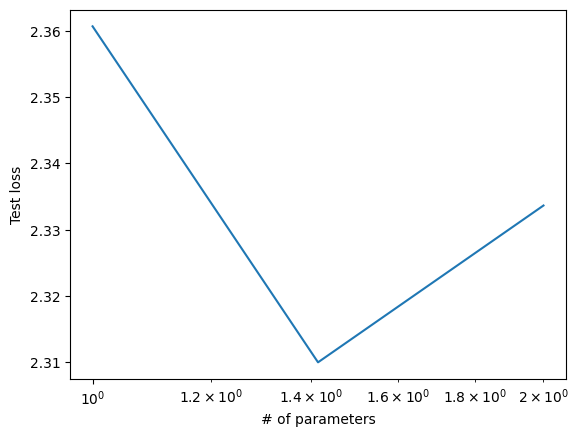

In [17]:
def plot_size_losses(model_sizes: list[float], losses: list[float]):
    """Plot losses."""
    # for ls in losses:
    plt.plot(model_sizes, losses)
    plt.xscale("log")
    plt.xlabel("# of parameters")
    plt.ylabel("Test loss")
    plt.show()
    
scaling_losses = list(map(lambda tup: tup[1], model_scaling_results))
print(scaling_losses)
# plot_losses(WIDTH_MULTIPLIERS, [scaling_losses[0::3], scaling_losses[1::3], scaling_losses[2::3]])
plot_size_losses(WIDTH_MULTIPLIERS, scaling_losses)

In [10]:
FRACS = list(2. ** np.arange(-5, 0))

def scale_dataset(
    fracs = FRACS,
    epochs=1,
    n_trials=1,
) -> tuple[list[float], list[nn.Module], list[float]]:
    """Scale dataset."""
    _fracs = []
    models = []
    losses = []

    for f in fracs:
        for i in range(n_trials):
            print(f"Training on {f * 100:.1f}% of the data (Trial {i})")
            train_loader = get_data_loader(train_set, f_train=f, seed=i)
            
            model = make_cnn()
            test_loss = train_mnist(model, train_loader, test_loader, epochs=epochs)
            
            _fracs.append(f)
            models.append(model)
            losses.append(test_loss)

    return _fracs, models, losses


fracs, models, losses = scale_dataset(n_trials=3)

Training on 3.1% of the data (Trial 0)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.456524
Train Epoch: 1 [640/60000 (33%)]	Loss: 2.558050
Train Epoch: 1 [1280/60000 (67%)]	Loss: 2.341950

Test set: Average loss: 2.3275, Accuracy: 980/10000 (10%)

Training on 3.1% of the data (Trial 1)
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.370396
Train Epoch: 1 [640/60000 (33%)]	Loss: 2.416930
Train Epoch: 1 [1280/60000 (67%)]	Loss: 2.382628


KeyboardInterrupt: 

[2.3216096366882324, 2.3461633323669435, 2.317033684539795]


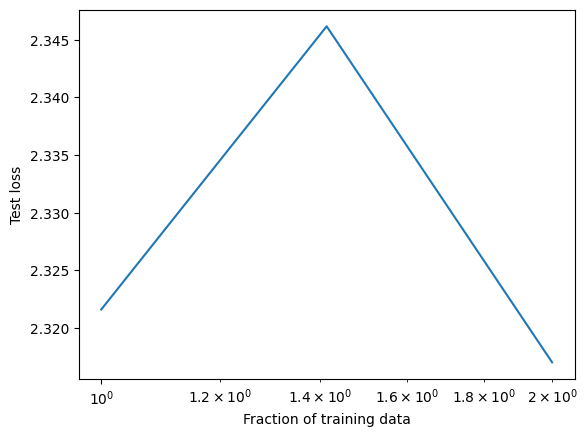

In [13]:

def plot_losses(fracs: list[float], losses: list[list[float]]):
    """Plot losses."""
    for ls in losses:
        plt.plot(fracs, ls)
    plt.xscale("log")
    plt.xlabel("Fraction of training data")
    plt.ylabel("Test loss")
    plt.show()
    
plot_losses(FRACS, [losses[0::3], losses[1::3], losses[2::3]])